In [11]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from aws.s3_utils import save_dataframe_to_s3, load_dataframe_from_s3, save_model_to_s3, load_model_from_s3
from sklearn.preprocessing import OneHotEncoder


In [13]:
df = load_dataframe_from_s3('data/box_scores/current.parquet')

# Validate box scores data structure
required_box_score_cols = ['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'MIN', 'MATCHUP']
missing_cols = [col for col in required_box_score_cols if col not in df.columns]
if missing_cols:
    error_msg = f"Missing required columns in box scores data: {missing_cols}"
    print(error_msg)

if 'MIN' in df.columns:
    original_count = len(df)
    df = df[df['MIN'] != 0]
    print(f"Filtered from {original_count} to {len(df)} records (MIN != 0)")

print(df.head())

Filtered from 26306 to 26206 records (MIN != 0)
  SEASON_ID  PLAYER_ID     TEAM_ID TEAM_ABBREVIATION      PLAYER TEAM  \
0     22024    1630639  1610612761               TOR  Toronto Raptors   
1     22024    1630639  1610612761               TOR  Toronto Raptors   
2     22024    1630639  1610612761               TOR  Toronto Raptors   
3     22024    1630639  1610612761               TOR  Toronto Raptors   
4     22024    1630639  1610612761               TOR  Toronto Raptors   

      GAME_ID  GAME_DATE      MATCHUP WL  MIN  ...  PTS  PLUS_MINUS   FP  \
0  0022400397 2024-12-23    TOR @ NYK  L    4  ...    3           5  3.0   
1  0022400414 2024-12-26    TOR @ MEM  L    5  ...    6          -4  8.4   
2  0022400449 2024-12-31    TOR @ BOS  L    4  ...    0          -8  1.2   
3  0022400608 2025-01-21  TOR vs. ORL  W    1  ...    2          -3  2.0   
4  0022400816 2025-02-23  TOR vs. PHX  W    1  ...    0           0  1.2   

   VIDEO_AVAILABLE       PLAYER  CLUSTER  Last3_FP_Avg  

In [14]:
players_df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')
clustered_players_df = load_dataframe_from_s3('data/clustered_players/current.parquet')

# Use a left merge to add the 'CLUSTER' column to players_df
dataset_clusters = pd.merge(players_df, clustered_players_df[['PLAYER', 'CLUSTER']], on='PLAYER', how='left')

print(dataset_clusters.head())

   id  PLAYER_ID         PLAYER TEAM   AGE    GP     W     L   MIN  OFFRTG  \
0   1    1630639    a.j. lawson  TOR  24.0  26.0  14.0  12.0  18.7   109.7   
1   2    1631260       aj green  MIL  25.0  73.0  44.0  29.0  22.7   114.0   
2   3    1642358     aj johnson  WAS  20.0  29.0   8.0  21.0  22.0   104.1   
3   4     203932   aaron gordon  DEN  29.0  51.0  33.0  18.0  28.4   122.5   
4   5    1628988  aaron holiday  HOU  28.0  62.0  39.0  23.0  12.8   110.3   

   ...  BLK_PERCENT  OPP_PTS_OFFTO  OPP_PTS_2ND_CHANCE  OPP_PTS_FB  \
0  ...        0.154            6.8                 6.5         7.0   
1  ...        0.048            7.5                 5.9         6.6   
2  ...        0.049            8.3                 8.2         8.3   
3  ...        0.121           10.9                 8.0         9.3   
4  ...        0.120            4.6                 3.8         3.6   

   OPP_PTS_PAINT  DEFWS  STAT_TYPE         SCRAPED_DATE   SOURCE  CLUSTER  
0           20.0  0.064   advanced

In [15]:
dataset_clusters.head(10)

,id,PLAYER_ID,PLAYER,TEAM,AGE,GP,W,L,MIN,OFFRTG,...,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS,STAT_TYPE,SCRAPED_DATE,SOURCE,CLUSTER
0,1,1630639,a.j. lawson,TOR,24.0,26.0,14.0,12.0,18.7,109.7,...,0.154,6.8,6.5,7.0,20.0,0.064,advanced,2025-08-27 20:27:32,NBA_API,13.0
1,2,1631260,aj green,MIL,25.0,73.0,44.0,29.0,22.7,114.0,...,0.048,7.5,5.9,6.6,21.6,0.100,advanced,2025-08-27 20:27:32,NBA_API,7.0
2,3,1642358,aj johnson,WAS,20.0,29.0,8.0,21.0,22.0,104.1,...,0.049,8.3,8.2,8.3,23.8,0.045,advanced,2025-08-27 20:27:32,NBA_API,1.0
3,4,203932,aaron gordon,DEN,29.0,51.0,33.0,18.0,28.4,122.5,...,0.121,10.9,8.0,9.3,30.6,0.080,advanced,2025-08-27 20:27:32,NBA_API,14.0
4,5,1628988,aaron holiday,HOU,28.0,62.0,39.0,23.0,12.8,110.3,...,0.120,4.6,3.8,3.6,12.8,0.074,advanced,2025-08-27 20:27:32,NBA_API,12.0
5,6,1630174,aaron nesmith,IND,25.0,45.0,29.0,16.0,24.9,120.1,...,0.137,6.9,7.6,6.4,26.3,0.081,advanced,2025-08-27 20:27:32,NBA_API,3.0
6,7,1630598,aaron wiggins,OKC,26.0,76.0,62.0,14.0,22.9,120.7,...,0.098,5.7,7.9,5.4,21.4,0.107,advanced,2025-08-27 20:27:32,NBA_API,3.0
7,8,1641745,adam flagler,OKC,25.0,37.0,34.0,3.0,5.5,99.1,...,0.158,1.5,1.6,1.2,4.5,0.041,advanced,2025-08-27 20:27:32,NBA_API,NaN
8,9,1641766,adama sanogo,CHI,23.0,4.0,2.0,2.0,5.4,104.2,...,0.000,3.3,1.8,1.8,4.0,0.001,advanced,2025-08-27 20:27:32,NBA_API,NaN
9,10,1641737,adem bona,PHI,22.0,58.0,12.0,46.0,15.6,107.4,...,0.600,5.9,5.3,5.2,15.8,0.040,advanced,2025-08-27 20:27:32,NBA_API,4.0


In [16]:
# clusterDict = {}
df.describe()

,PLAYER_ID,TEAM_ID,GAME_DATE,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,PF,PTS,PLUS_MINUS,FP,VIDEO_AVAILABLE,CLUSTER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,2.620600e+04,2.620600e+04,26206,26206.000000,26206.000000,26206.000000,24832.000000,26206.000000,26206.000000,20941.000000,...,26206.000000,26206.000000,26206.000000,26206.000000,26206.0,22772.000000,26206.000000,26206.000000,26206.000000,26206.000000
mean,1.407952e+06,1.610613e+09,2025-01-17 04:50:47.485308672,22.657788,3.913837,8.376860,0.456605,1.270854,3.527856,0.335007,...,1.745325,10.684805,0.000916,21.808128,1.0,6.913842,21.670893,21.578882,21.508226,20.890795
min,2.544000e+03,1.610613e+09,2024-10-22 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-58.000000,-3.000000,1.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.628365e+06,1.610613e+09,2024-12-01 00:00:00,15.000000,1.000000,4.000000,0.333000,0.000000,1.000000,0.000000,...,1.000000,4.000000,-7.000000,10.100000,1.0,3.000000,11.900000,12.180000,12.214286,12.044900
50%,1.630170e+06,1.610613e+09,2025-01-17 00:00:00,24.000000,3.000000,7.000000,0.467000,1.000000,3.000000,0.333000,...,2.000000,9.000000,0.000000,20.000000,1.0,7.000000,20.133333,20.090000,19.985714,19.145584
75%,1.631159e+06,1.610613e+09,2025-03-04 00:00:00,31.000000,6.000000,12.000000,0.600000,2.000000,5.000000,0.500000,...,3.000000,16.000000,7.000000,31.300000,1.0,10.000000,29.866667,29.500000,29.342857,28.152706
max,1.642530e+06,1.610613e+09,2025-04-13 00:00:00,53.000000,22.000000,39.000000,1.000000,12.000000,20.000000,1.000000,...,6.000000,61.000000,48.000000,98.300000,1.0,14.000000,81.600000,80.120000,75.671429,72.200000
std,5.214558e+05,8.651212e+00,NaN,10.777663,3.239540,6.012377,0.236916,1.530327,3.148558,0.283789,...,1.434259,8.790497,11.727859,14.872508,0.0,3.966854,12.949025,12.511230,12.318256,11.808098


In [17]:
# Map the 'Cluster' column from clusterdf to the dataset based on 'Player'
clusterDict = dataset_clusters.set_index('PLAYER')['CLUSTER'].to_dict()

# Map the 'CLUSTER' column in the dataset
df['CLUSTER'] = df['PLAYER'].map(clusterDict)

In [18]:
# Remove players without a cluster
# df = df.dropna(subset=['CLUSTER'])
df.sort_values(by=['GAME_DATE'], ascending = [False], inplace=True)
print(df['CLUSTER'].value_counts(dropna=False))


CLUSTER
NaN     3434
7.0     2573
3.0     2555
1.0     2175
8.0     2030
10.0    1899
11.0    1593
4.0     1464
13.0    1451
6.0     1382
2.0     1362
14.0    1253
9.0     1233
5.0     1024
12.0     612
0.0      166
Name: count, dtype: int64


In [19]:
print("Data type:", df['MIN'].dtype)
df['MIN'] = pd.to_numeric(df['MIN'], errors='coerce')
print("Data type:", df['MIN'].dtype)
print(df['MIN'].head(10))
df['MIN'] = df['MIN'] + np.random.uniform(-3, 3, size=len(df))
df['MIN'] = df['MIN'].clip(lower=0)
df['MIN']

Data type: int64
Data type: int64
15152     5
18016    39
10690    16
16430    15
25707    17
4110     31
12356    33
22015    23
20933    43
24051    12
Name: MIN, dtype: int64


15152     7.070461
18016    39.970879
10690    17.401241
16430    13.391688
25707    15.792816
           ...    
1641      7.492932
14205    31.276940
16734    33.937811
5061     13.385152
21810    36.691027
Name: MIN, Length: 26206, dtype: float64

In [20]:
# Replace NaN with a placeholder before encoding
df['CLUSTER'] = df['CLUSTER'].fillna('CLUSTER_NAN')

# Parse MATCHUP to extract home/away and opponent
def parse_matchup(matchup_str):
    if pd.isna(matchup_str):
        return 0, 'UNKNOWN'
    matchup_str = str(matchup_str)
    if ' @ ' in matchup_str:
        # Away game: "TOR @ NYK"
        teams = matchup_str.split(' @ ')
        return 0, teams[1] if len(teams) > 1 else 'UNKNOWN'
    elif ' vs. ' in matchup_str:
        # Home game: "TOR vs. PHX" 
        teams = matchup_str.split(' vs. ')
        return 1, teams[1] if len(teams) > 1 else 'UNKNOWN'
    else:
        return 0, 'UNKNOWN'

# Apply parsing
matchup_parsed = df['MATCHUP'].apply(parse_matchup)
df['IS_HOME'] = matchup_parsed.apply(lambda x: x[0])
df['OPPONENT'] = matchup_parsed.apply(lambda x: x[1])

print(f"Parsed MATCHUP: {(df['IS_HOME'] == 1).sum()} home games, {(df['IS_HOME'] == 0).sum()} away games")

# Calculate rest days first
from datetime import datetime, timezone, timedelta
import pytz

def calculate_rest_days(df):
    """Calculate rest days for each player based on their previous game"""
    # Create a copy to avoid modifying the original
    df_sorted = df.copy()
    
    # Ensure GAME_DATE is datetime
    df_sorted['GAME_DATE'] = pd.to_datetime(df_sorted['GAME_DATE'])
    
    # Sort by player and game date (ascending for proper calculation)
    df_sorted = df_sorted.sort_values(['PLAYER', 'GAME_DATE'])
    
    # Calculate days since last game for each player
    df_sorted['PREV_GAME_DATE'] = df_sorted.groupby('PLAYER')['GAME_DATE'].shift(1)
    df_sorted['REST_DAYS'] = (df_sorted['GAME_DATE'] - df_sorted['PREV_GAME_DATE']).dt.days - 1
    
    # For first games (no previous game), set rest days to 3 (reasonable default)
    df_sorted['REST_DAYS'] = df_sorted['REST_DAYS'].fillna(3).astype(int)
    
    # For predictions (current games), calculate rest days from most recent game to today
    # Get current date in ET timezone
    et_tz = pytz.timezone('America/New_York')
    today = datetime.now(et_tz).date()
    
    # Get most recent game for each player
    most_recent_games = df_sorted.groupby('PLAYER')['GAME_DATE'].max().reset_index()
    most_recent_games['MOST_RECENT_DATE'] = most_recent_games['GAME_DATE']
    
    # Merge back and update REST_DAYS for prediction cases
    df_sorted = df_sorted.merge(most_recent_games[['PLAYER', 'MOST_RECENT_DATE']], on='PLAYER', how='left')
    
    # Calculate rest days from most recent game to today for predictions
    current_rest_days = (pd.Timestamp(today) - df_sorted['MOST_RECENT_DATE']).dt.days
    
    # For the most recent games, use the calculated rest days from today
    is_most_recent = df_sorted['GAME_DATE'] == df_sorted['MOST_RECENT_DATE']
    df_sorted.loc[is_most_recent, 'REST_DAYS'] = current_rest_days[is_most_recent]
    
    # Clean up temporary columns
    df_sorted = df_sorted.drop(columns=['PREV_GAME_DATE', 'MOST_RECENT_DATE'])
    
    # Ensure REST_DAYS is non-negative and reasonable (cap at 30 days for outliers)
    df_sorted['REST_DAYS'] = df_sorted['REST_DAYS'].clip(0, 30)
    
    print(f"Rest days calculated: min={df_sorted['REST_DAYS'].min()}, max={df_sorted['REST_DAYS'].max()}, mean={df_sorted['REST_DAYS'].mean():.2f}")
    
    return df_sorted

# Calculate rest days
df = calculate_rest_days(df)
print(f"Rest days distribution:")
print(df['REST_DAYS'].value_counts().head(10))

# Now create features and labels with REST_DAYS included
featureNames = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS']
labelName = ['FP']
dfFeatures = df[featureNames]
dfLabels = df[labelName]
# Ensures Cluster and Opponent are categorical variables; one-hot encoded
dfFeatures = pd.get_dummies(dfFeatures, columns=['CLUSTER', 'OPPONENT'], drop_first=False)

Parsed MATCHUP: 13123 home games, 13083 away games
Rest days calculated: min=1, max=30, mean=3.58
Rest days distribution:
REST_DAYS
2     13571
3      4057
1      3942
4      1341
30      722
5       694
8       372
6       299
7       261
9       186
Name: count, dtype: int64


In [21]:
labels = np.array(dfLabels).ravel()  # Fix: flatten to 1D array to avoid sklearn warning
features = np.array(dfFeatures)

In [22]:
df = df[['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS']]
players = df['PLAYER']
gameDates = df['GAME_DATE']

In [23]:
train, test, trainLabels, testLabels, trainPlayers, testPlayers, trainDates, testDates= train_test_split(features, labels, players, gameDates, test_size=0.25, random_state=30)
testPlayers = testPlayers.reset_index(drop=True)
testDates = testDates.reset_index(drop=True)


In [24]:
import pickle

# Load the pre-trained model from AWS instead of training locally
print("Loading pre-trained RandomForest model from AWS...")
rf = load_model_from_s3("models/RFCluster.sav")
print("Model loaded successfully!")

Loading pre-trained RandomForest model from AWS...
Model loaded successfully!


In [25]:
train_predictions = rf.predict(train)
predictions = rf.predict(test)


In [26]:
# Create a mapping from one-hot encoded columns back to cluster numbers
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
reverse_cluster_map = {i: col.split('_')[-1] for i, col in enumerate(cluster_columns, start=1)}

In [27]:
# Create a mapping from one-hot encoded columns back to cluster and opponent values
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
opponent_columns = [col for col in dfFeatures.columns if col.startswith('OPPONENT_')]

feature_columns = dfFeatures.columns
df = pd.DataFrame(test, columns = feature_columns)

# Map back to original cluster and opponent values
df['CLUSTER'] = df[cluster_columns].idxmax(axis=1) if cluster_columns else 'UNKNOWN'
df['OPPONENT'] = df[opponent_columns].idxmax(axis=1) if opponent_columns else 'UNKNOWN'

# Map back to original cluster numbers safely
def safe_cluster_map(value):
    if isinstance(value, str) and value.startswith('CLUSTER_'):
        try:
            cluster_value = value.split('_')[-1]
            return float(cluster_value) if cluster_value != 'NAN' else np.nan
        except ValueError:
            return np.nan
    return np.nan

def safe_opponent_map(value):
    if isinstance(value, str) and value.startswith('OPPONENT_'):
        return value.split('_', 1)[-1]  # Get everything after first underscore
    return 'UNKNOWN'

df['CLUSTER'] = df['CLUSTER'].map(safe_cluster_map)
df['OPPONENT'] = df['OPPONENT'].map(safe_opponent_map)

# Drop the one-hot encoded columns if no longer needed
df = df.drop(columns=cluster_columns + opponent_columns)
df['PLAYER'] = testPlayers
df['GAME_DATE'] = testDates
df['ACTUAL'] = testLabels
df['PREDICTED'] = predictions
df['ERROR'] = abs(df['ACTUAL'] - df['PREDICTED'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [28]:
# Old DF
# df.describe()

In [29]:
df.describe()

,CLUSTER,GAME_DATE,ACTUAL,PREDICTED,ERROR
count,5715.000000,6552,6552.000000,6552.000000,6552.000000
mean,6.850919,2025-01-16 22:32:31.648351488,21.933654,22.033531,5.104917
min,0.000000,2024-10-22 00:00:00,-2.000000,-0.921000,0.000000
25%,3.000000,2024-12-01 00:00:00,10.100000,11.747000,1.727000
50%,7.000000,2025-01-17 00:00:00,20.100000,20.578500,4.021500
75%,10.000000,2025-03-04 00:00:00,31.300000,30.953500,7.406250
max,14.000000,2025-04-13 00:00:00,90.000000,84.069000,38.645000
std,3.953063,NaN,15.026524,13.538514,4.390679


In [30]:
df.head(5)

,PLAYER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,MIN,IS_HOME,REST_DAYS,CLUSTER,OPPONENT,GAME_DATE,ACTUAL,PREDICTED,ERROR
0,demar derozan,35.0,37.54,36.542857,35.323636,32.463001,0,2,8.0,DAL,2025-03-03,27.4,39.230,11.830
1,onyeka okongwu,37.133333,34.74,37.914286,28.130769,27.599782,0,2,11.0,MIN,2025-01-27,15.9,33.515,17.615
2,grayson allen,23.133333,20.88,21.642857,20.259459,30.668369,1,2,7.0,MIN,2025-01-29,24.9,25.514,0.614
3,bruno fernando,7.866667,5.66,7.942857,8.8125,11.438269,0,1,NaN,LAL,2024-11-10,7.0,8.355,1.355
4,keegan murray,21.166667,22.72,25.214286,26.793103,29.100999,1,1,3.0,IND,2024-12-22,20.8,20.842,0.042


In [31]:
save_dataframe_to_s3(df, 'data/test_player_predictions/current.parquet')
players_df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')
clustered_players_df = load_dataframe_from_s3('data/clustered_players/current.parquet')

# Use a left merge to add the 'CLUSTER' column to players_df
dataset_clusters = pd.merge(players_df, clustered_players_df[['PLAYER', 'CLUSTER']], on='PLAYER', how='left')

print(dataset_clusters.head())

Saved 6552 records to s3://nba-prediction-ibracken/data/test_player_predictions/current.parquet
   id  PLAYER_ID         PLAYER TEAM   AGE    GP     W     L   MIN  OFFRTG  \
0   1    1630639    a.j. lawson  TOR  24.0  26.0  14.0  12.0  18.7   109.7   
1   2    1631260       aj green  MIL  25.0  73.0  44.0  29.0  22.7   114.0   
2   3    1642358     aj johnson  WAS  20.0  29.0   8.0  21.0  22.0   104.1   
3   4     203932   aaron gordon  DEN  29.0  51.0  33.0  18.0  28.4   122.5   
4   5    1628988  aaron holiday  HOU  28.0  62.0  39.0  23.0  12.8   110.3   

   ...  BLK_PERCENT  OPP_PTS_OFFTO  OPP_PTS_2ND_CHANCE  OPP_PTS_FB  \
0  ...        0.154            6.8                 6.5         7.0   
1  ...        0.048            7.5                 5.9         6.6   
2  ...        0.049            8.3                 8.2         8.3   
3  ...        0.121           10.9                 8.0         9.3   
4  ...        0.120            4.6                 3.8         3.6   

   OPP_PTS_PAI

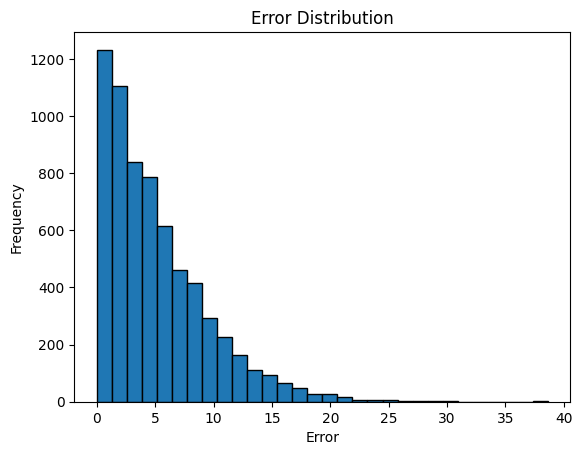

In [32]:
import matplotlib.pyplot as plt

plt.hist(df['ERROR'], bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

In [33]:
# Identfy unique list of cluster to loop over
dataset_clusters.head()

,id,PLAYER_ID,PLAYER,TEAM,AGE,GP,W,L,MIN,OFFRTG,...,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS,STAT_TYPE,SCRAPED_DATE,SOURCE,CLUSTER
0,1,1630639,a.j. lawson,TOR,24.0,26.0,14.0,12.0,18.7,109.7,...,0.154,6.8,6.5,7.0,20.0,0.064,advanced,2025-08-27 20:27:32,NBA_API,13.0
1,2,1631260,aj green,MIL,25.0,73.0,44.0,29.0,22.7,114.0,...,0.048,7.5,5.9,6.6,21.6,0.100,advanced,2025-08-27 20:27:32,NBA_API,7.0
2,3,1642358,aj johnson,WAS,20.0,29.0,8.0,21.0,22.0,104.1,...,0.049,8.3,8.2,8.3,23.8,0.045,advanced,2025-08-27 20:27:32,NBA_API,1.0
3,4,203932,aaron gordon,DEN,29.0,51.0,33.0,18.0,28.4,122.5,...,0.121,10.9,8.0,9.3,30.6,0.080,advanced,2025-08-27 20:27:32,NBA_API,14.0
4,5,1628988,aaron holiday,HOU,28.0,62.0,39.0,23.0,12.8,110.3,...,0.120,4.6,3.8,3.6,12.8,0.074,advanced,2025-08-27 20:27:32,NBA_API,12.0


In [34]:
clusterList = dataset_clusters['CLUSTER'].tolist()

In [35]:
uniqueClusterList = list(set(clusterList))
uniqueClusterList

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

In [36]:
# ClusterError = 0
# for cluster in uniqueClusterList:
#     clusterdf = dataset[dataset['CLUSTER'] == cluster]
#     dfFeatures = clusterdf[['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg']]
#     dfLabels = clusterdf[['FP']]

#     labels = np.array(dfLabels).ravel()
#     features = np.array(dfFeatures)

#     train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=4)

#     reg = RandomForestRegressor(random_state=4)
#     reg.fit(train, train_labels)

#     train_predictions = reg.predict(train)
#     predictions = reg.predict(test)

#     df0 = pd.DataFrame(test, columns = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg'])
#     df0['Actual'] = test_labels
#     df0['Predicted'] = predictions
#     df0['Error'] = abs(df0['Actual'] - df0['Predicted'])
#     ClusterError += df0['Error'].mean()

#     print(f"Cluster {cluster} average error is roughly {df0['Error'].mean()}")
# avgClusterError = ClusterError/len(uniqueClusterList)
# print(f"Average error across clusters is: {avgClusterError}")